In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from PIL import Image
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

## BIG TODO: 
1. GENERATE ARROWS ON THE MAP SO THAT ACTIONS WHICH LEAD TO SAME MAX Q VALUE WILL BE DRAWN INSTEAD OF ONLY ONE
2. FIND SUITABLE HYPERPARAMETERS FOR MONTE CARLO SO THAT IT RUNS ON SLIPPERY FROZEN LAKE AS WELL; AS OF NOW FOR THE CURRENT HYPERPARAMETERS SET IN MONTE CARLO, IT FAILS 

In [62]:
GRID_SIZE = 8

random_map = generate_random_map(size=GRID_SIZE)
env = gym.make("FrozenLake-v1", is_slippery=False, map_name=f"{GRID_SIZE}x{GRID_SIZE}", render_mode="rgb_array", desc=random_map)
env.reset() # observation, info

(0, {'prob': 1})

#### SET UP THE TRANSITION MATRIX, REWARD FUNCTION, DISCOUNT FACTOR AS WELL AS NO OF STATES AND ACTIONS FOR THE VALUE ITERATION ALGORITHM

In [63]:
no_of_states = env.observation_space.n
no_of_actions = env.action_space.n
print(f"There are {no_of_states} states and {no_of_actions} actions.")

V = np.zeros(shape=(no_of_states))
policy = np.random.choice([0, 1, 2, 3], size=(no_of_states))

T = np.zeros(shape=(no_of_states, no_of_actions, no_of_states))
R = np.zeros(shape=(no_of_states, no_of_actions, no_of_states))

# discount factor
gamma = 0.9

# extract the environment matrix
P = env.unwrapped.P

for state in range(no_of_states):
    for action in range(no_of_actions):
        for prob, next_state, reward, _ in P[state][action]:
            T[state, action, next_state] += prob
            R[state, action, next_state] = reward

There are 64 states and 4 actions.


#### THIS FUNCTION RENDERS THE POLICY AS ARROWS ALONG WITH THE ACTION VALUES

In [64]:
def print_policy(policy, action_names):
    """Converts policy to arrows to display."""
    policy_arrows = ['←', '↓', '→', '↑']
    return [policy_arrows[action] if action_names[i] != 'H' and action_names[i] != 'G' else ' ' for i, action in enumerate(policy)]

def render_with_value_policy(env, value_function, policy):
    """Renders the environment, displaying the value function and policy."""
    desc = env.unwrapped.desc.tolist()
    desc = [[c.decode('utf-8') for c in line] for line in desc]
    policy_symbols = print_policy(policy, sum(desc, []))

    print("Value Function and Policy")
    for i in range(env.unwrapped.nrow):
        for j in range(env.unwrapped.ncol):
            idx = i * env.unwrapped.ncol + j
            if desc[i][j] in ('G', 'H'):
                print(" %s " % desc[i][j], end="")
            else:
                print(" %.2f%s" % (value_function[idx], policy_symbols[idx]), end="")
        print("")

# Example usage
render_with_value_policy(env, V, policy)

Value Function and Policy
 0.00↓ 0.00← 0.00↑ 0.00→ 0.00→ 0.00↑ 0.00→ 0.00↓
 0.00← H  0.00← 0.00← 0.00← 0.00→ 0.00↑ 0.00←
 H  0.00↓ 0.00← 0.00← 0.00↑ 0.00↓ 0.00↑ 0.00↑
 H  0.00↑ 0.00→ H  0.00← 0.00↓ 0.00↓ 0.00↑
 0.00↓ 0.00↓ 0.00↓ 0.00↓ 0.00↓ 0.00← H  0.00→
 0.00← 0.00↓ H  0.00← 0.00← 0.00← H  0.00←
 H  0.00← 0.00↓ 0.00→ 0.00← H  0.00→ 0.00←
 0.00→ 0.00← 0.00↑ 0.00↓ 0.00→ 0.00↓ 0.00↑ G 


#### THIS FUNCTION OVERLAYS THE OUTPUT OF ABOVE FUNCTION ONTO THE ACTUAL FROZENLAKE RGB ARRAY WE GET FROM THE ENV

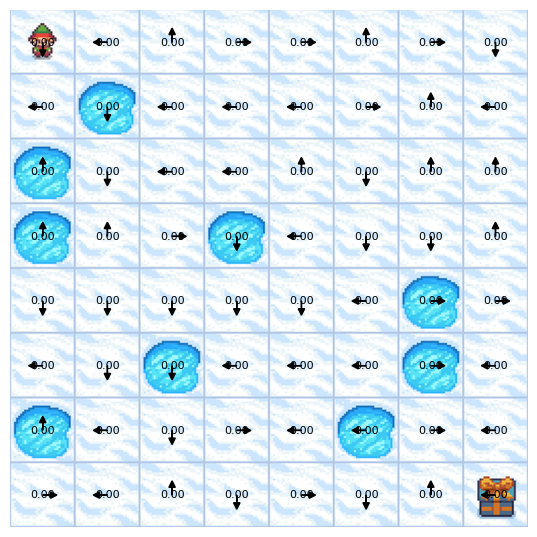

In [65]:
def resize_image(image, new_width, new_height):
    image_pil = Image.fromarray(image)
    resized_image = image_pil.resize((new_width, new_height), Image.LANCZOS)
    return np.array(resized_image)

def overlay_value_policy_on_image(image, value_function, policy, grid_size=(GRID_SIZE, GRID_SIZE), cell_size=84, offset=None):
    if offset is None:
        offset = cell_size // 2

    # Calculate the new image size
    new_width = grid_size[1] * cell_size
    new_height = grid_size[0] * cell_size

    # Resize the image
    resized_image = resize_image(image, new_width, new_height)

    # Calculate figure size in inches (assuming 100 pixels/inch)
    dpi = 100
    fig_size_width = new_width / dpi
    fig_size_height = new_height / dpi

    fig, ax = plt.subplots(figsize=(fig_size_width, fig_size_height), dpi=dpi)
    ax.imshow(resized_image)
    ax.axis('off')  # Hide the axes

    policy_arrows = {0: (-0.5, 0), 1: (0, 0.5), 2: (0.5, 0), 3: (0, -0.5)}
    for i in range(np.prod(grid_size)):
        row, col = divmod(i, grid_size[1])
        y, x = row * cell_size + offset, col * cell_size + offset

        # Display value function in black text
        ax.text(x, y, f'{value_function[i]:.2f}', color='black', ha='center', va='center', fontsize=8)

        # Display policy as arrows
        dx, dy = policy_arrows[policy[i]]
        ax.arrow(x, y, dx*20, dy*20, head_width=cell_size/10, head_length=cell_size/10, fc='black', ec='black')

    plt.show()


# Generate an initial render of the environment to get the base image
image = env.render()

# Use the custom function to overlay the value function and policy
overlay_value_policy_on_image(image, V, policy)

#### BELOW FUNCTION IMPLEMENTS THE VALUE ITERATION ALGORITHM AS WELL AS EXTRACTS THE POLICY ONCE THE ALGORITHM CONVERGES

In [66]:
def value_iteration_and_extract_policy(T, R, num_states, num_actions, gamma=0.95, theta=0.001):
    """
    Performs value iteration algorithm for a given environment and extracts the optimal policy.

    Parameters:
    - T: Transition probabilities matrix of shape [num_states, num_actions, num_states].
    - R: Reward matrix of shape [num_states, num_actions, num_states].
    - num_states: Number of states in the environment.
    - num_actions: Number of actions in the environment.
    - gamma: Discount factor.
    - theta: Threshold for convergence.

    Returns:
    - V: The optimal value function.
    - policy: The optimal policy.
    """
    V = np.zeros(num_states)  # Initialize value function
    
    while True:
        delta = 0
        for s in range(num_states):
            v = V[s]
            # Break down the value function update to separately compute expected reward and expected value
            action_values = np.zeros(num_actions)
            for a in range(num_actions):
                for s_prime in range(num_states):
                    action_values[a] += T[s, a, s_prime] * (R[s, a, s_prime] + gamma * V[s_prime])
            V[s] = np.max(action_values)
            delta = max(delta, abs(v - V[s]))
        
        if delta < theta:
            break

    # Extracting the policy from the value function
    policy = np.zeros(num_states, dtype=int)
    for s in range(num_states):
        action_values = np.zeros(num_actions)
        for a in range(num_actions):
            for s_prime in range(num_states):
                action_values[a] += T[s, a, s_prime] * (R[s, a, s_prime] + gamma * V[s_prime])
        policy[s] = np.argmax(action_values)
    
    return V, policy

In [67]:
V, policy = value_iteration_and_extract_policy(T, R, no_of_states, no_of_actions)

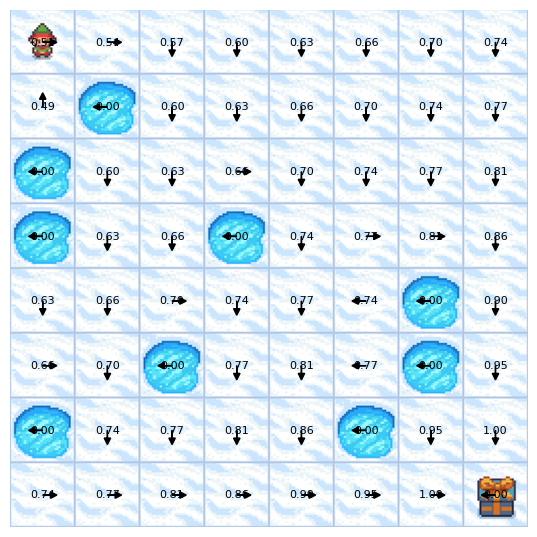

In [68]:
# Generate an initial render of the environment to get the base image
image = env.render()

# Use the custom function to overlay the value function and policy
overlay_value_policy_on_image(image, V, policy)

#### THIS FUNCTION IMPLEMENTS THE MONTE CARLO CONTROL ALGORITHM WITH DECAYING EPSILONS AND RETURNS POLICY AS WELL THE REWARDS PER EACH EPISODE

In [107]:
def monte_carlo(env, gamma=1, epsilon_start=1.0, epsilon_decay=1e-6, num_episodes=100000):
    # Extract environment information
    no_of_states = env.observation_space.n
    no_of_actions = env.action_space.n
    
    # Initialize Q-values, visit counts, and policy
    Q = np.zeros((no_of_states, no_of_actions))
    N = np.zeros((no_of_states, no_of_actions))
    policy = np.random.choice(no_of_actions, size=no_of_states)
    
    # Initialize list to store rewards
    rewards = []
    
    # Define epsilon-greedy policy
    def epsilon_greedy_policy(state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.choice(no_of_actions)
        else:
            return policy[state]
    
    # Iterate over episodes
    for episode in range(num_episodes):
        state = env.reset()  # Reset environment
        terminated = False
        episode_rewards = 0  # Cumulative reward for the episode
        
        episode_steps = []  # Store episode steps
        while not terminated:
            if isinstance(state, tuple):
                state = state[0]
            action = epsilon_greedy_policy(state, epsilon_start)
            next_state, reward, terminated, _, _ = env.step(action)  # Unpack only the first four values
            episode_rewards += reward
            episode_steps.append((state, action, reward))
            state = next_state
            
            if terminated:
                break  # Break the loop if the episode is done

        # print(episode_steps)
        
        # Update Q-values and policy
        for t, (state, action, reward) in enumerate(episode_steps):
            G = sum([gamma**i * step[2] for i, step in enumerate(episode_steps[t:])])  # Compute return
            N[state, action] += 1
            Q[state, action] += (1 / N[state, action]) * (G - Q[state, action])  # Incremental update
            policy[state] = np.argmax(Q[state, :])
        
        # Decay epsilon
        epsilon_start = max(epsilon_start - epsilon_decay, 0.1)  # Ensure epsilon never drops below 0.1
        
        # Append cumulative reward for the episode to rewards list
        rewards.append(episode_rewards)
    
    return Q, policy, rewards



In [108]:
Q_values, learned_policy, rewards = monte_carlo(env)
learned_policy

array([2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 3, 1, 3, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 3, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 3, 0, 1, 3, 1, 2, 1,
       1, 0, 2, 1, 1, 1, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2])

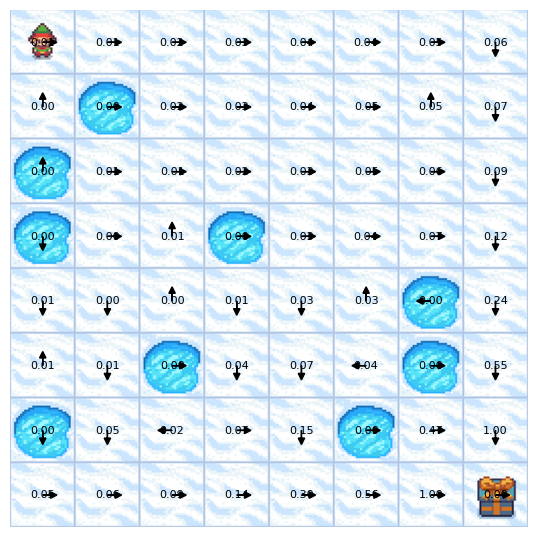

In [109]:
def compute_value_function(Q):
    value_function = np.max(Q, axis=1)
    return value_function

# Assuming Q is your final Q-values obtained from the GLIE Monte Carlo algorithm
value_function = compute_value_function(Q_values)

# Generate an initial render of the environment to get the base image
env.reset()
image = env.render()

# Use the custom function to overlay the value function and policy
overlay_value_policy_on_image(image, value_function, learned_policy)

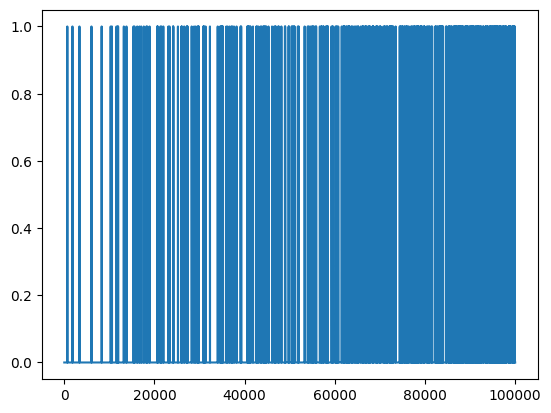

In [110]:
plt.plot(rewards)

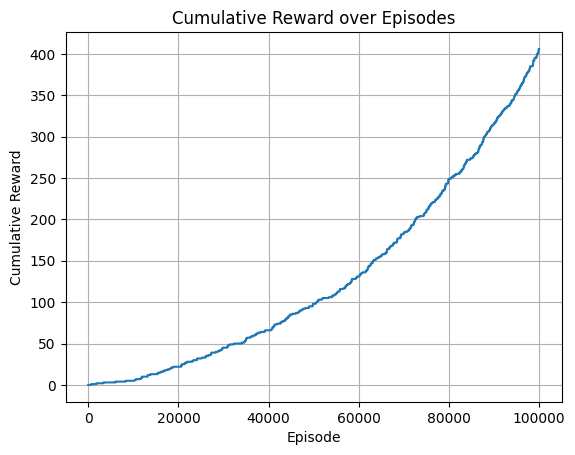

In [111]:
import matplotlib.pyplot as plt

def plot_cumulative_reward(rewards):
    cumulative_rewards = np.cumsum(rewards)
    episodes = np.arange(1, len(rewards) + 1)
    
    plt.plot(episodes, cumulative_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward over Episodes')
    plt.grid(True)
    plt.show()


    
plot_cumulative_reward(rewards)

#### The above graph shows how sample inefficient monte carlo is. Since each episode gives reward of +1 on completion and 0 when not completed; we can say that the cumulative reward effectively represents number of episodes completed. So you can see that in 100000 trials monte carlo effectively completed only 400 full episodes